# Transfer Learning Exercises

In [ ]:
# Import useful libraries        (note: don't forget to turn on GPU)

# tensorflow for network building/training
import tensorflow as tf
from tensorflow.python.keras import Model, Sequential
from tensorflow.keras.applications import VGG16

# Basic operating system (os), numerical, and plotting functionality
import os
import time
import numpy as np
from matplotlib import pylab as plt

# scikit-learn data utilities
!pip install scikit-image
from sklearn.model_selection import train_test_split
from skimage import transform

# scikit-learn performance metric utilities
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Color transformations
from skimage.color import rgb2lab

#Skimage resizing 
from skimage.transform import resize

# Garbage collection (for saving RAM during training)
import gc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 101.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 KB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 122.5 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


## VGG16 Model

For this exercise you'll now use the VGG16 model as the feature extractor. https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16

Specifications:
- Default input size: 224x224, no smaller than 32x32 pixels
- Default output classes: 1000

Our images are 150x150 pixels in size and come from only **eight categories**. In order to use this model for our classification task, we again can/need to do the following:
* Resize images : Our input images can be resized to the appropriate dimensions. Alternatively, we can pad our images to the expected dimensions. Padding leads to additional choices - Do we pad with zeros, duplicate edge pixels or mirror the image across edges?
* Change the prediction layer : Remove the existing prediction layer and add a new layer that can predict **8 classes**.
* Train : Finally, we need to train the network on our data

## Load Data

Getting path and changing directories

In [ ]:
# Define the current directory and the directory where the files to download can
# be found
current_dir = os.getcwd()
remote_path = 'https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/NotebookExampleData/Week3/data_nuclei/crc/'

# Define and build a directory to save this data in
data_dir = os.path.join(current_dir, 'crc_data')
if not os.path.isdir(data_dir):
  os.mkdir(data_dir)

# Move into the data directory and download all of the files
os.chdir(data_dir)
for ii in range(1, 6):
    basename = f'rgb0{ii}.npz'
    filename = os.path.join(remote_path, basename)

    # Check if the file has already been downloaded
    if not os.path.isfile(basename):
      cmd = f'wget {filename}'
      print(cmd)
      os.system(cmd)

# Return to the original directory
os.chdir(current_dir)

Function for loading images

In [ ]:
# Define a function to load the data from the assumed download path
def load_images(colorspace='rgb'):
    """
    Loads the example data and applies transformation into requested colorspace

    Arguments
    ---------
    colorspace : str, optional, default: `rgb`
        The colorspace into which the images should be transformed. Accepted
        values include

        'rgb' : Standard red-green-blue color-space for digital images

        'gray' or 'grey': An arithmetic average of the (r, g, b) values

        'lab': The CIE L*a*b* colorspace
    
    Returns
    -------
    images : numpy.ndarray, shape (Nimg, Ny, Nx, Ncolor)
        The complete set of transformed images

    labels : numpy.ndarray, shape (Nimg)
        The classification labels associated with each entry in `images`

    label_to_str : dict
        A dictionary which converts the numerical classification value in
        `labels` into its string equivalent representation.
    """
    # Check that the colorspace argument is recognized
    colorspace_lower = colorspace.lower()
    if colorspace_lower not in ['rgb', 'gray', 'grey', 'lab']:
        raise ValueError(f'`colorspace` value of {colorspace} not recognized')

    # Load data, which is stored as a numpy archive file (.npz)
    filename = os.path.join(data_dir, 'rgb01.npz')
    print(f'loading {filename}')
    tmp = np.load(os.path.join(data_dir, 'rgb01.npz'), allow_pickle=True)

    # Parse the loaded data into images and labels
    # Initialize the images and labels variables using the first archive data
    images = tmp['rgb_data']
    if colorspace_lower == 'rgb':
        pass
    elif colorspace_lower in ['gray', 'grey']:
        images = np.mean(images, axis=-1)      # Average into grayscale
    elif colorspace_lower == 'lab':
        images = rgb2lab(images)               # Convert to CIE L*a*b*

    # Grab the initial array for the image labels
    labels = tmp['labels']
    
    # Grab the dictionary to convert numerical labels to their string equivalent
    label_to_str = tmp['label_str']
    label_to_str = label_to_str.tolist() # Convert label_to_str into a dict

    # Update the user on the number and size of images loaded
    print('Loaded images with shape {}'.format(images.shape))
    del tmp

    # Loop over each of the remaining archives and append the contained data
    for ii in range(2,6):
        # Build the full path to the archive and load it into memory
        filename = os.path.join(data_dir, f'rgb0{ii}.npz')
        print(f'loading {filename}')
        tmp = np.load(filename, allow_pickle=True)

        # Parse and append the data
        these_images = tmp['rgb_data']
        if colorspace_lower == 'rgb':
            pass
        elif (colorspace_lower == 'gray') or (colorspace_lower == 'grey'):
            these_images = np.mean(these_images, axis=-1) # Convert to grayscale
        elif colorspace_lower == 'lab':
            these_images = rgb2lab(these_images)          # Convert to CIEL*a*b*

        # Append the images and labels
        images = np.append(images, these_images, axis=0)
        labels = np.append(labels, tmp['labels'], axis=0)

        # Update the user on the number and size of images
        print('Loaded images with shape {}'.format(these_images.shape))
        del tmp

    # Force the image data to be floating point and print the data shape
    images = images.astype(np.float)
    print('Final image data shape: {}'.format(images.shape))
    print('Number of image labels: {}'.format(*labels.shape))

    return images, labels, label_to_str

Load images and labels into memory

In [ ]:
images_full_res, labels, label_to_str = load_images()
num_classes = np.unique(labels).size

loading /work/Week3/03_TransferLearning/crc_data/rgb01.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Week3/03_TransferLearning/crc_data/rgb02.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Week3/03_TransferLearning/crc_data/rgb03.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Week3/03_TransferLearning/crc_data/rgb04.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Week3/03_TransferLearning/crc_data/rgb05.npz
Loaded images with shape (1000, 150, 150, 3)
<ipython-input-3-6e89b8146558>:86: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  images = images.astype(np.float)
Final image data shape: (5000, 150, 

## Pre-process the Images

***Note: you'll have to edit a line of code in the cell for resizing***

Resizing

In [ ]:
# This boolean can be switched to false if you do not want to resize the images
resize_images_bool = True

# Specify a new shape to use for the resized images
# NOTE: For the VGG16 model, we must use a size of at least (32, 32).
original_shape = images_full_res.shape
print(original_shape)
new_shape = list(original_shape)
new_shape[1:3] = (32,32)## YOUR CODE HERE

# Compute if we are downsampling (in which case we need anti-aliasing)
scaling_ratio = np.array(new_shape[1:3])/np.array(original_shape[1:3])
anti_alias = np.any(scaling_ratio < 1)

# If resizing is requested, then run the resizing transformation
if resize_images_bool:
    # Grab the original shape of the images
    num_images = images_full_res.shape[0]

    # Initialize an array for storing the resized images
    images = np.zeros(new_shape, dtype=np.float16)

    # Loop over each image in the data and perform a resizing operation
    for img_num, img_data in enumerate(images_full_res):
        # Update the user on progress
        if np.mod(img_num, 1000) == 0:
            print(f'Processing image number {img_num}')

        # Process the image and force it to be a 16-bit float
        processed_img = transform.resize(img_data, new_shape[1:],
                                         anti_aliasing=anti_alias)
        images[img_num] = processed_img.astype(np.float16)

# If no resizing requested, then just rename that data
else:
    images = images_full_res

# Remove the full-resolution versions from memory (just clogging things up)
del images_full_res

(5000, 150, 150, 3)
Processing image number 0
Processing image number 1000
Processing image number 2000
Processing image number 3000
Processing image number 4000


Normalize the images (if it hasn't been done already)

In [ ]:
# Note, we cast image data as float16 to save RAM
images = images.astype(np.float16)/255.0

Include an axis for color channels

In [ ]:
# Take note of number of color channels in the loaded image add a last axis to 
# images ndarray if array dimension is only 3 (as is the case with grayscale images)
if images.ndim == 3:
    # If image is grayscale, then we add a last axis (of len 1) for channel
    n_channels = 1
    images = images[:, : , :, np.newaxis]
    print('\nlast dimension added to images ndarray to account for channel')
    print(f'new images.shape: {images.shape}')
else:
    #if image is not grayscale, last dimension of image already corresponds to channel
    n_channels = images.shape[-1]

Split data into train and test sets

In [ ]:
# Split data into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=.2)

# Convert 'labels' (1D array of integers) to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

# Print sizes of train/test sets
print(f'train_images.shape: {train_images.shape}')
print(f'train_labels.shape: {train_labels.shape}')
print(f'test_images.shape: {test_images.shape}')
print(f'test_labels.shape: {test_labels.shape}')

# Print the one-hot encoded labels as a sanity check
print('one-hot encoded labels:')
print(train_labels)

# Get rid of the duplicate copies of the data
del images, labels

train_images.shape: (4000, 32, 32, 3)
train_labels.shape: (4000, 8)
test_images.shape: (1000, 32, 32, 3)
test_labels.shape: (1000, 8)
one-hot encoded labels:
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Load Pre-trained VGG16 Model

here's the link to documentation again (https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16), also reference the tutorial notebook

In [ ]:
# Create the base pre-trained model
print('loading VGG16')
base_model = tf.keras.applications.VGG16(input_shape=train_images.shape[1:], include_top=False, weights='imagenet')
print('done')

loading VGG16
58889256/58889256 [==============================] - 0s 0us/step
done


Summarize model structure

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Freezing layers

In [ ]:
# Play around with freezing layers, take a look at the tutorial notebook for reference 
# Define some functions for experimenting with unfreezing layers
def unfreeze_layers(model, top_n_layers):
    """Makes the top layers of the `base_model` trainable (except batch norm)"""
    # We unfreeze the top layers while leaving BatchNorm layers frozen
    for layer in model.layers[-top_n_layers:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

def freeze_layers(model, top_n_layers):
    """Makes the top layers of the `base_model` untrainable"""
    # We unfreeze the top layers while leaving BatchNorm layers frozen
    for layer in model.layers[-top_n_layers:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

# By default we'll just freeze the entire base model again
base_model.trainable = False

Modify the pre-trained network by adding a few new layers at the output, including a classification layer (remember we want to predict 8 different classes)

In [ ]:
# Add a global spatial average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Add a fully-connected layer
## YOUR CODE HERE
prediction_layer1 = tf.keras.layers.Dense(64, activation='relu')
# Add the final classification layer
## YOUR CODE HERE
prediction_layer2 = tf.keras.layers.Dense(num_classes, activation='softmax')
# Build the model you will train
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer1,
    prediction_layer2
])

# Print summary of model layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 14,748,040
Trainable params: 33,352
Non-trainable params: 14,714,688
_________________________________________________________________


Compiling model

In [ ]:
# Compile the model (should be done *after* setting layers to non-trainable)
    # optimizer: rmsprop
    # loss: categorical crossentropy
    # metrics: accuracy
  
## YOUR CODE HERE
# Specify the loss function to use
loss_func = tf.keras.losses.categorical_crossentropy

# Use the RMSprop learning algorithm to optimize the network weights
base_learning_rate = 0.0001
opt = tf.keras.optimizers.RMSprop(lr=base_learning_rate)

# Compile the model using the specified loss function and potimizer
model.compile(loss=loss_func, optimizer=opt, metrics=['accuracy'])

/shared-libs/python3.9/py/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## Train model

Train the model on the new, histological, data

In [ ]:
# Convert all of our training and validation ('test') data to TensorFlow data
# This prevents the training algorithm from needing to make a *copy* of your
# numpy arrays, which would EAT UP SOO MUCH RAM!
#
# It also accelerates training a bit because there is no data-conversion step
train_images_tf = tf.constant(train_images, dtype=tf.float16)
test_images_tf = tf.constant(test_images)
del train_images, test_images

train_labels_tf = tf.constant(train_labels, dtype=tf.float16)
test_labels_tf = tf.constant(test_labels)
del train_labels, test_labels

Train model

In [ ]:
# This function is called after each epoch
# (It will ensure that your training process does not consume all available RAM)
class garbage_collect_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

# Time how long it takes the model to train for these epochs
start_time = time.time()

# Perform the training method
history = model.fit(train_images_tf,
                    train_labels_tf,
                    batch_size=64,
                    epochs= 50,
                    verbose=1,
                    validation_data=(test_images_tf, test_labels_tf),
                    callbacks = [garbage_collect_callback()])

stop_time = time.time()
print("--- %s seconds ---" % (stop_time - start_time))

Epoch 1/50
63/63 [==============================] - 6s 77ms/step - loss: 1.8355 - accuracy: 0.3282 - val_loss: 1.6779 - val_accuracy: 0.4870
Epoch 2/50
63/63 [==============================] - 5s 73ms/step - loss: 1.5899 - accuracy: 0.5375 - val_loss: 1.4667 - val_accuracy: 0.5990
Epoch 3/50
63/63 [==============================] - 5s 74ms/step - loss: 1.4091 - accuracy: 0.6115 - val_loss: 1.3040 - val_accuracy: 0.6460
Epoch 4/50
63/63 [==============================] - 5s 73ms/step - loss: 1.2662 - accuracy: 0.6478 - val_loss: 1.1769 - val_accuracy: 0.6640
Epoch 5/50
63/63 [==============================] - 5s 72ms/step - loss: 1.1561 - accuracy: 0.6722 - val_loss: 1.0841 - val_accuracy: 0.6840
Epoch 6/50
63/63 [==============================] - 5s 73ms/step - loss: 1.0722 - accuracy: 0.6870 - val_loss: 1.0072 - val_accuracy: 0.6870
Epoch 7/50
63/63 [==============================] - 5s 73ms/step - loss: 1.0034 - accuracy: 0.6977 - val_loss: 0.9444 - val_accuracy: 0.7050
Epoch 8/50
63

Plot model train/validation accuracy and model train/validation loss

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


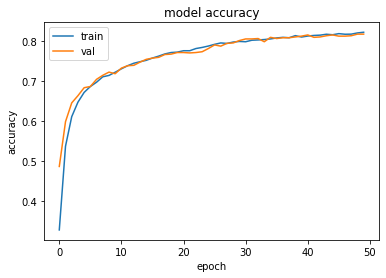

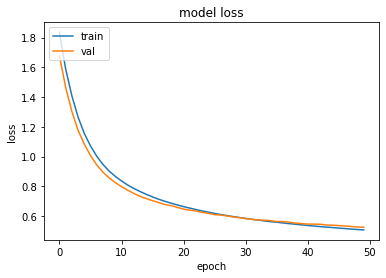

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Make Predictions for Test Images

In [ ]:
# Predict class of test each test
predictions = model.predict(test_images_tf, verbose=True)

# Convert the predictions and true labels into category numbers
test_true_labels = test_labels_tf.numpy().argmax(axis=1)
test_pred_labels = predictions.argmax(axis=1)

32/32 [==============================] - 1s 34ms/step


<ipython-input-18-99981e8a322d>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.imshow(test_images_tf[ii+100,:,:,:].numpy().astype(np.float))


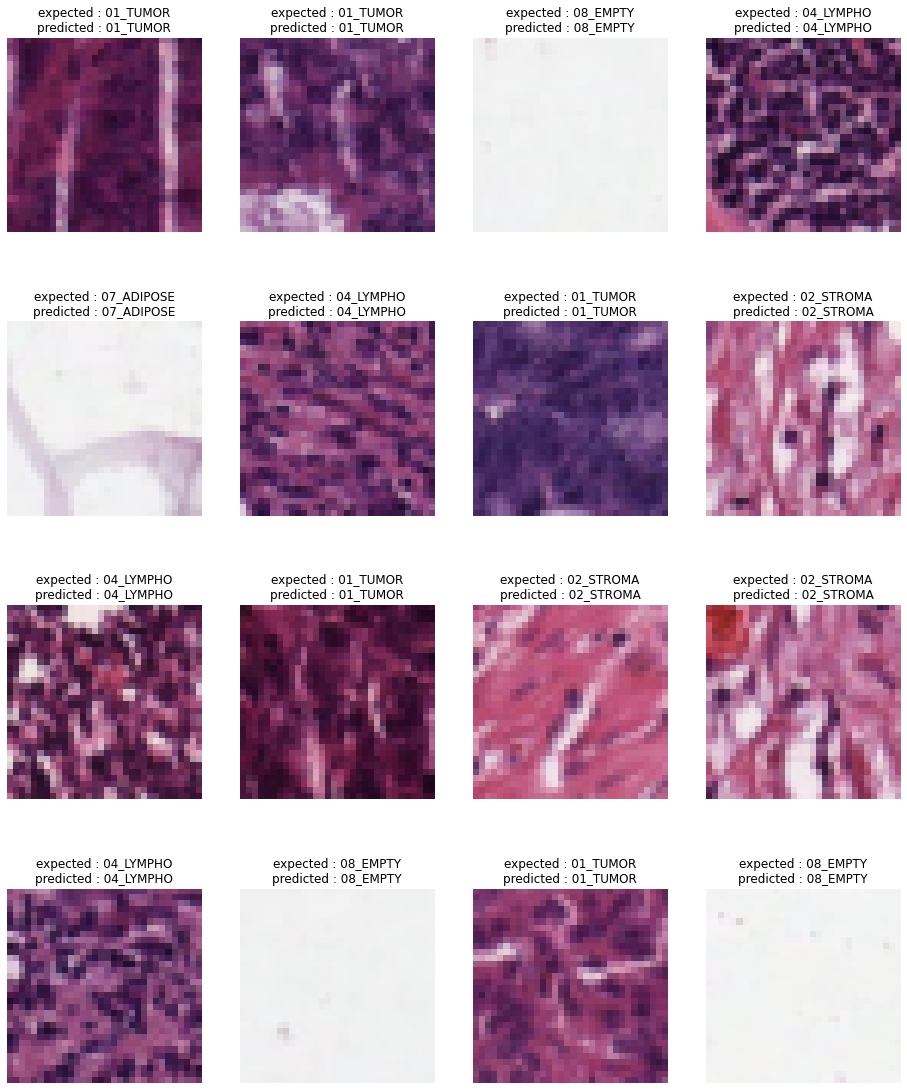

In [ ]:
# Plot a set of test images, along with predicted labels and true labels
plt.figure(figsize=(16,20))
for ii in range(0, 16):
    # Activate subplot and display image
    plt.subplot(4,4,ii+1)
    plt.imshow(test_images_tf[ii+100,:,:,:].numpy().astype(np.float))

    # Turn off axes
    plt.axis('off')

    # Add annotaiton
    plt.title('expected : ' + label_to_str[test_true_labels[ii+100]]
              + '\npredicted : ' + label_to_str[test_pred_labels[ii+100]])
plt.show()

## Accuracy

In [ ]:
acc = accuracy_score(test_true_labels, test_pred_labels)
print(f'Model Accuracy: {acc:.2%}')

Model Accuracy: 81.80%


Confusion matrix

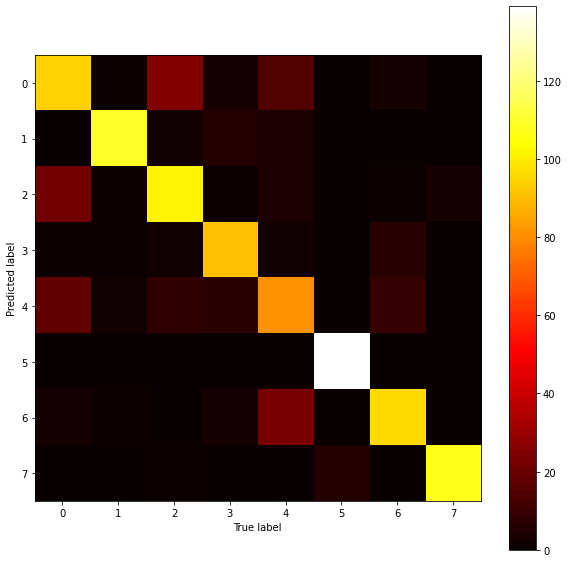

In [ ]:
conf_mat = confusion_matrix(test_true_labels, test_pred_labels)

# Generate a new figure
plt.figure(figsize=(10,10))

# Display the confusion matrix
plt.imshow(conf_mat, cmap='hot', interpolation='nearest')

# Add some anotation for the plot
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

### To-do:

Continue playing around with preprocessing (image size) and the model (added layers, freezing layers, optimizer, # epochs) and see their effects on the accuracy. Doing this may help you for the challenge problem :O

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fb7bd75a-6937-4069-a25e-888dc9081eb5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>